# CSCA 5642 Week 5 Project
In this project, monet style transformation will be applied to the provided photos directory, then submitted as output. A GAN will be used to accomplish this task.

## Setup 

### Import Libraries

In [1]:
## Imports

import time
import shutil
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import os

### Load Data

In [2]:
## Load data helper functions

def read_record(img):
    record = {"image": tf.io.FixedLenFeature([], tf.string)}
    img = tf.io.parse_single_example(img, record)
    image = img['image']
    image = tf.image.decode_jpeg(image, channels = 3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_data(fnams):
    data = tf.data.TFRecordDataset(fnams)
    data = data.map(read_record, num_parallel_calls=tf.data.AUTOTUNE)
    return data

def prepare_data(data):
    data = data.cache()
    data = data.shuffle(800)
    data = data.batch(3)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [3]:
## Load the datasets

monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

monet_data = load_data(monet_files)
photos_data = load_data(photo_files)

monet_data = prepare_data(monet_data)
photos_data = prepare_data(photos_data)

sample_photo = next(iter(photos_data))

## Exploratory Data Analysis

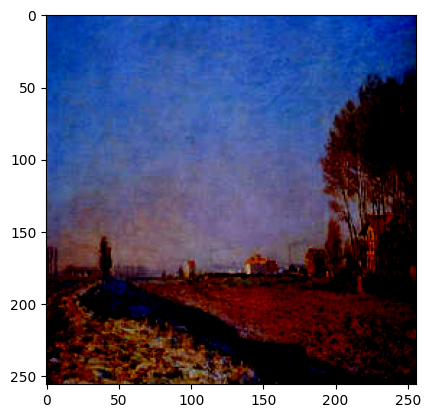

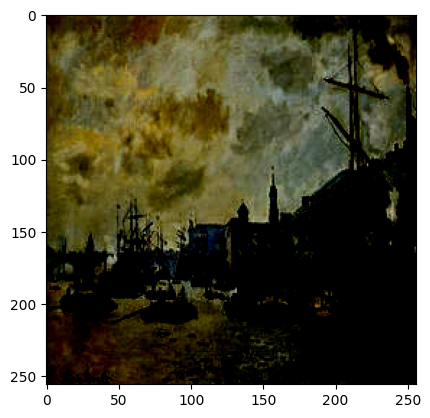

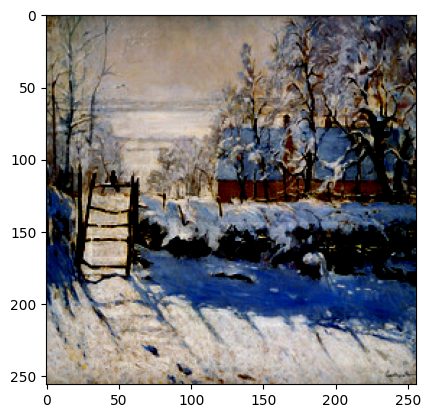

In [4]:
## Visualize example monet photos to train the GAN with

for img in list(monet_data)[0]:
    plt.imshow(img)
    plt.show()

In [5]:
list(monet_data)[0][0].shape # image dimensions

TensorShape([256, 256, 3])

In [6]:
len(monet_files) # tfrec batch

5

## Model Development and Analysis

### Define Helper Functions

In [7]:
## Helper functions upscaling and downscaling images

def instance_normalization(epsilon = 1e-4):
    return tf.keras.layers.LayerNormalization(center = True, scale = True, epsilon = epsilon)

def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0, 0.03)
    res = tf.keras.Sequential()
    res.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))
    res.add(instance_normalization())
    if apply_dropout:
        res.add(tf.keras.layers.Dropout(0.4))
    res.add(tf.keras.layers.ReLU())
    
    return res

def downsample(filters, size, apply_instancenorm = True):
    initializer = tf.random_normal_initializer(0, 0.03)
    res = tf.keras.Sequential()
    conv_layer = tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False)
    res.add(conv_layer)
    if apply_instancenorm:
        res.add(instance_normalization())
    relu_layer = tf.keras.layers.LeakyReLU()
    res.add(relu_layer)
    
    return res

In [8]:
## Instantiate the Discriminator and the Generator

def Discriminator():
    initializer = tf.random_normal_initializer(0, 0.03)
    input = tf.keras.layers.Input(shape = [256, 256, 3], name = 'input_image')
    val = input
    down_a = downsample(64, 4, False)(val)
    down_b = downsample(128, 4)(down_a)
    down_c = downsample(256, 4)(down_b)
    zero_pad_a = tf.keras.layers.ZeroPadding2D()(down_c)
    convolution = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad_a)
    normalized = instance_normalization()(convolution)
    leaky_rel = tf.keras.layers.LeakyReLU()(normalized)
    zero_pad_b = tf.keras.layers.ZeroPadding2D()(leaky_rel)
    output = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad_b)
    
    return tf.keras.Model(inputs = input, outputs = output)

def Generator():
    inputs = tf.keras.layers.Input(shape = [256, 256, 3])
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    initializer = tf.random_normal_initializer(0, 0.03)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer = initializer, activation = 'tanh')
    val = inputs
    downsampled = []
    for down in down_stack:
        val = down(val)
        downsampled.append(val)
    downsampled = reversed(downsampled[:-1])
    for up, downsampled_item in zip(up_stack, downsampled):
        val = up(val)
        val = tf.keras.layers.Concatenate()([val, downsampled_item])
    val = last(val)
    
    return tf.keras.Model(inputs = inputs, outputs = val)

In [9]:
gen_g_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1 = 0.4)
gen_f_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1 = 0.4)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1 = 0.4)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1 = 0.4)
discriminator_x = Discriminator()
discriminator_y = Discriminator()
gen_g = Generator()
gen_f = Generator()
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [10]:
ckpt = tf.train.Checkpoint(generator_g = gen_g,
                           generator_f = gen_f,
                           discriminator_x = discriminator_x,
                           discriminator_y = discriminator_y,
                           generator_g_optimizer = gen_g_optimizer,
                           generator_f_optimizer = gen_f_optimizer,
                           discriminator_x_optimizer = discriminator_x_optimizer,
                           discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints/train", max_to_keep = 5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Checkpoint Restored.')

In [11]:
## Helper functions for discriminator and generator loss, along with saving images

def discrim_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.45

def generate_and_save(gan, tensor, out_path, file):
    prediction = gan(tensor)
    plt.imshow(prediction[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.savefig(os.path.join(out_path, file), pad_inches = 0, bbox_inches = 'tight')
    plt.close()

def gen_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 25 * loss1

def id_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 25 * 0.5 * loss


### Train the Model

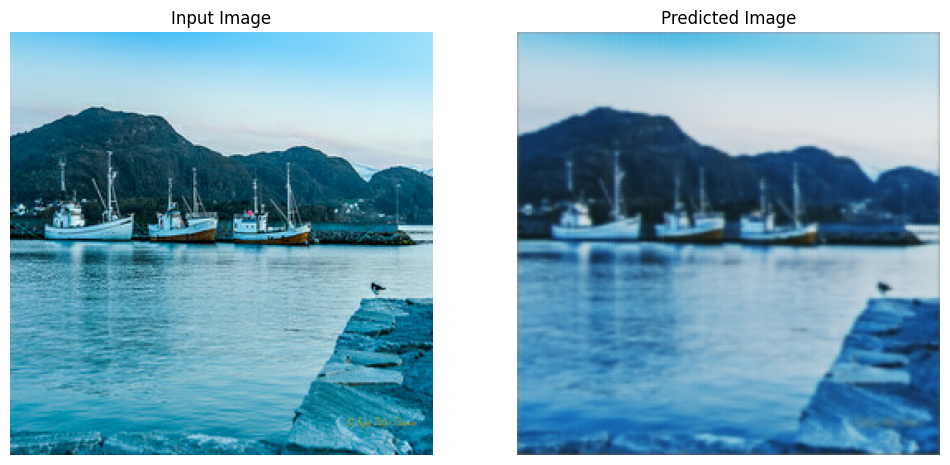

Epoch 0 completed in 21.4 minutes.


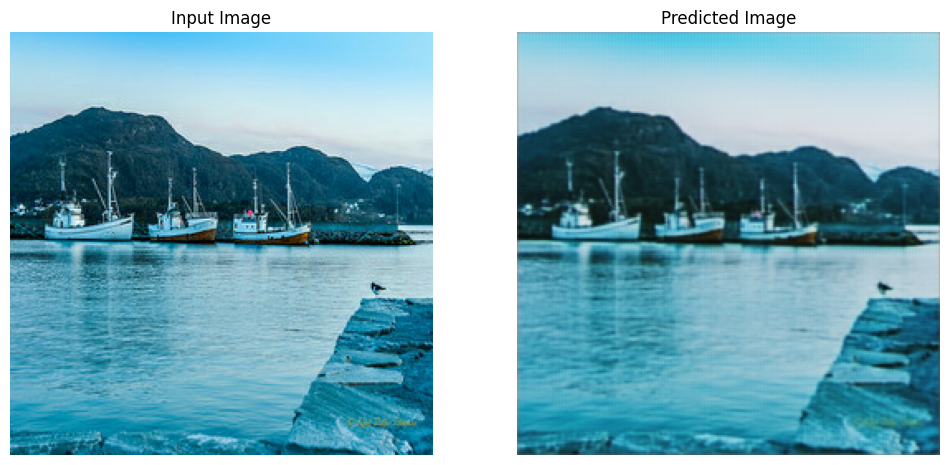

Epoch 1 completed in 19.8 minutes.


In [12]:
## Fit and train the GAN

def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent = True) as tape:
        fake_y = gen_g(real_x, training = True)
        cycled_x = gen_f(fake_y, training = True)
        fake_x = gen_f(real_y, training = True)
        cycled_y = gen_g(fake_x, training = True)
        same_x = gen_f(real_x, training = True)
        same_y = gen_g(real_y, training = True)
        disc_real_x = discriminator_x(real_x, training = True)
        disc_real_y = discriminator_y(real_y, training = True)
        disc_fake_x = discriminator_x(fake_x, training = True)
        disc_fake_y = discriminator_y(fake_y, training = True)
        gen_g_loss = gen_loss(disc_fake_y)
        gen_f_loss = gen_loss(disc_fake_x)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss(real_x, same_x)
        disc_x_loss = discrim_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discrim_loss(disc_real_y, disc_fake_y)
    gen_g_gradients = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
    gen_f_gradients = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    gen_g_optimizer.apply_gradients(zip(gen_g_gradients, gen_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gen_f_gradients, gen_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

for epoch in range(2):
    start_time = time.time()
    for img_x, img_y in tf.data.Dataset.zip((monet_data, photos_data)):
        train_step(img_x, img_y)
    generate_images(gen_g, sample_photo)
    print(f"Epoch {epoch} completed in {((time.time() - start_time) / 60):.3} minutes.")

## Results and Conclusion

In [13]:
## Generate and save the style transformed images

def generate_and_save(gan, tensor, out_path, file):
    prediction = gan(tensor)
    prediction = prediction[0] * 0.5 + 0.5
    #print(prediction.shape, prediction)
    prediction = prediction.numpy()
    if prediction.dtype == np.float32:
        prediction = (prediction * 255).astype(np.uint8)
    elif prediction.max() <= 1.0:
         prediction = (prediction * 255).astype(np.uint8)
    if prediction.ndim > 3:
        prediction = prediction[0]
    #print(type(numpy_array))
    img = Image.fromarray(prediction)
    #print(img.size, img)
    img.save(os.path.join(out_path, file))

in_dir = "/kaggle/input/gan-getting-started/photo_jpg"
out_dir = "/kaggle/working/images"
os.makedirs(out_dir, exist_ok = True)
for i, fname in enumerate(os.listdir(in_dir)[0:26]): # 7000 - 10000 required for submission
    if fname.endswith('.jpg'):
        img = Image.open(os.path.join(in_dir, fname))
        img_tensor = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
        img_tensor = tf.expand_dims(img_tensor, 0)
        generate_and_save(gen_g, img_tensor, out_dir, f'image_{i+1}.jpg')
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [14]:
out_dir = "../tmp/generated_images"
os.makedirs(out_dir, exist_ok=True)
with zipfile.ZipFile("images.zip", "w") as zipf:
    for i, fname in enumerate(os.listdir(in_dir)[0:7001]): # 7000 - 10000 required for submission
        if fname.endswith('.jpg'):
            img = Image.open(os.path.join(in_dir, fname))
            tensor = tf.convert_to_tensor(img, dtype = tf.float32) / 255.0
            tensor = tf.expand_dims(tensor, 0)
            # generate_and_save(gen_g, img_tensor, out_dir, f'image_{i+1}.jpg')
            file = f'image_{i+1}.jpg'

        # def generate_and_save(gan, tensor, out_path, file):
            prediction = gen_g(tensor)
            prediction = prediction[0] * 0.5 + 0.5
            #print(prediction.shape, prediction)
            prediction = prediction.numpy()
            if prediction.dtype == np.float32:
                prediction = (prediction * 255).astype(np.uint8)
            elif prediction.max() <= 1.0:
                 prediction = (prediction * 255).astype(np.uint8)
            if prediction.ndim > 3:
                prediction = prediction[0]
            #print(type(numpy_array))
            img = Image.fromarray(prediction)
            #print(img.size, img)
            img_dir = os.path.join(out_dir, file)
            img.save(img_dir)
            zipf.write(img_dir, os.path.basename(img_dir))

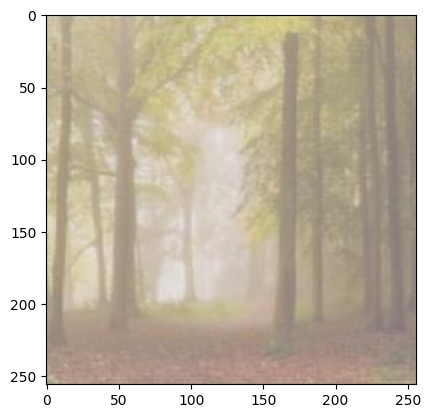

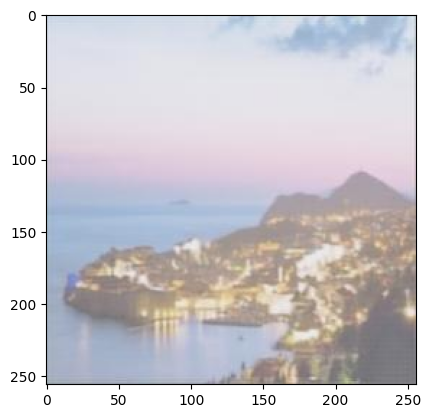

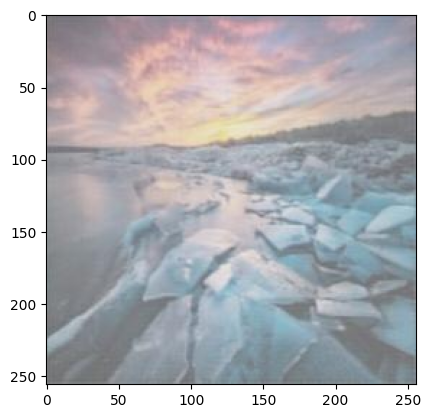

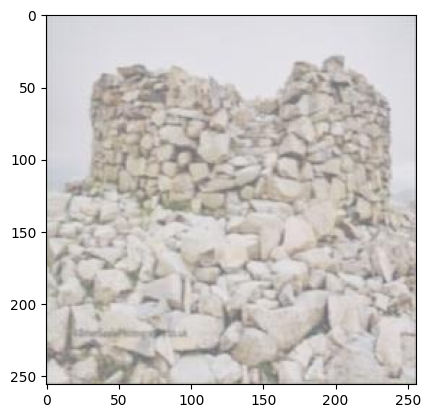

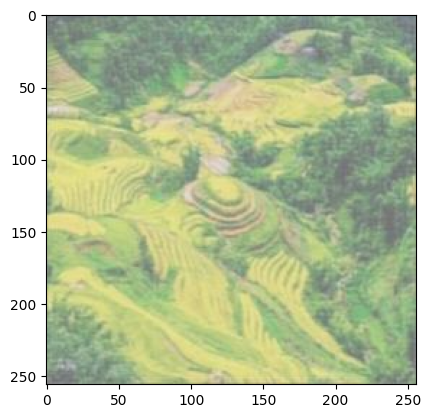

In [15]:
## Display examples of the transformed images

with zipfile.ZipFile('images.zip') as zf:
    count = 0
    for file in zf.namelist():
        with zf.open(file) as f:
            img = Image.open(f)
            plt.figure()
            plt.imshow(img)
            plt.show()
            count += 1
        if count == 5:
            break

Once the GAN has been trained, sample transformed images were generated. The Money style transformation has been applied. What went well included the image generation improvement after only a couple of training epochs. Ways to improve the project could include tweaking the epochs, loss, and various neural network hyperparemeters for the generator and discriminator.